In [157]:
from __future__ import print_function
import pandas as pd
import numpy as np
import re
import os
import pickle
import sys
import os.path
from datetime import datetime, date, time 
from dateutil.parser import parse
from time import strftime
import pyarrow
import requests
import json
import qwikidata
import qwikidata.sparql
import matplotlib.pyplot as plt

pd.options.display.max_rows = 1000

DATA_DIR  = '/Users/award40/Desktop/covidify-output/data/' + str(datetime.date(datetime.now()))
FILE  = 'agg_data_' + str(datetime.date(datetime.now())) + '.parquet.gzip'

#Create place to save diagrams
image_dir = './images/'
if not os.path.exists(image_dir):
    os.mkdir(image_dir)

In [158]:
# ! pip install qwikidata

In [159]:
def get_country_population(country):
    query = """
    SELECT ?population WHERE {
      SERVICE wikibase:mwapi {
          bd:serviceParam mwapi:search '%s' .    
          bd:serviceParam mwapi:language "en" .    
          bd:serviceParam wikibase:api "EntitySearch" .
          bd:serviceParam wikibase:endpoint "www.wikidata.org" .
          bd:serviceParam wikibase:limit 1 .
          ?item wikibase:apiOutputItem mwapi:item .
      }
      ?item wdt:P1082 ?population
    }
    """ % (country)
    res = qwikidata.sparql.return_sparql_query_results(query)
    try:
        return res['results']['bindings'][0]['population']['value']
    except:
        print(country, 'not a valid option.')
        #sys.exit()
    
print(get_country_population('Irelarnd')) # test invalid country

Irelarnd not a valid option.
None


In [160]:
COUNTRIES = ['China', 'Ireland', 'France', 'Italy', 'America']

In [161]:
country_dict = {'country': COUNTRIES, 'population': []}

for country in COUNTRIES:
    pop = get_country_population(country)
    country_dict['population'].append(pop)
    print(country + ': ' + pop)

country_dict

China: 1409517397
Ireland: 4761865
France: 66628000
Italy: 60599936
America: 325145963


{'country': ['China', 'Ireland', 'France', 'Italy', 'America'],
 'population': ['1409517397', '4761865', '66628000', '60599936', '325145963']}

In [162]:
df

,confirmed,country,date,datetime,deaths,file_date,province,recovered
0,1,China,2020-01-22,2020-01-22 17:00:00,0,2020-01-22,Anhui,0
18,0,China,2020-01-22,2020-01-22 17:00:00,0,2020-01-22,Jilin,0
1,14,China,2020-01-22,2020-01-22 17:00:00,0,2020-01-22,Beijing,0
2,6,China,2020-01-22,2020-01-22 17:00:00,0,2020-01-22,Chongqing,0
3,1,China,2020-01-22,2020-01-22 17:00:00,0,2020-01-22,Fujian,0
...,...,...,...,...,...,...,...,...
21287,3,America,2020-03-26,2020-03-26 23:48:35,0,2020-03-26,Louisiana,0
21286,3,America,2020-03-26,2020-03-26 23:48:35,0,2020-03-26,South Carolina,0
21307,2,America,2020-03-26,2020-03-26 23:48:35,0,2020-03-26,South Carolina,0
21381,5,America,2020-03-26,2020-03-26 23:48:35,0,2020-03-26,Louisiana,0


In [163]:
df = pd.read_parquet(os.path.join(DATA_DIR, FILE))
# df = df.sort_values()

# Convert types
for col in ['confirmed', 'deaths', 'recovered']:
    df[col] = df[col].replace('', 0).astype(int)
    
# for i, country in enumerate(COUNTRIES):
#     COUNTRIES[i] = country.lower()

In [164]:
COUNTRIES

['China', 'Ireland', 'France', 'Italy', 'America']

In [167]:
def get_country_cases(col, df, country):
    values = []
    
    for date in df.file_date.unique():
        tmp_df = df[df.file_date == date]
        try:
            values.append(tmp_df[tmp_df.country == country].confirmed.sum())
        except:
            values.append(0)
        
    return values


In [168]:
#filter dataframe
df = df[df.country.isin(COUNTRIES)]
test_df = pd.DataFrame([])
test_df['date'] = df.file_date.unique()

#Check if country not in filter dataframe
for country in COUNTRIES:
    if country not in df.country.values:
        print(country, 'not in list. Please check spelling')
    else:
        test_df[country.lower() + '_confirmed'] = get_country_cases('confirmed', df, country)

In [169]:
test_df

,date,china_confirmed,ireland_confirmed,france_confirmed,italy_confirmed,america_confirmed
0,2020-01-22,547,0,0,0,1
1,2020-01-23,639,0,0,0,1
2,2020-01-24,916,0,2,0,2
3,2020-01-25,1399,0,3,0,2
4,2020-01-26,2062,0,3,0,5
5,2020-01-27,2863,0,3,0,5
6,2020-01-28,5494,0,4,0,5
7,2020-01-29,6070,0,5,0,5
8,2020-01-30,8124,0,5,0,5
9,2020-02-01,11871,0,6,2,8


## Plotting

In [170]:
import matplotlib.pyplot as plt
%matplotlib inline
font = {'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

#set ggplot style
plt.style.use('ggplot')

In [171]:
col_list = [x for x in test_df.columns if x != 'date']

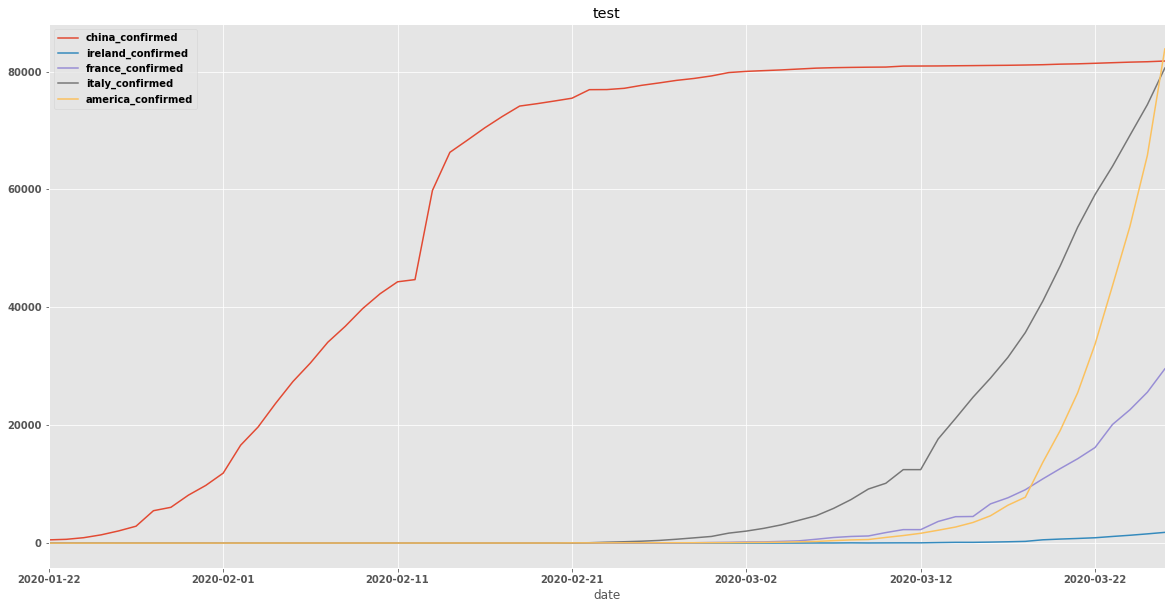

In [172]:
def plot_log(tmp_df, cols):
    fig, ax = plt.subplots(figsize=(20,10))
    tmp_df.groupby(['date'])[cols].sum().plot(ax=ax)
    
    ax.set_title('test')
    fig = ax.get_figure()
#     fig.savefig(os.path.join(image_dir, create_save_file(col, country, 'trendline')))

plot_log(test_df, col_list)
